# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [3]:
# Python Standard Library
# -----------------------
pass

In [4]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [5]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f


In [6]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [7]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [8]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [9]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [10]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

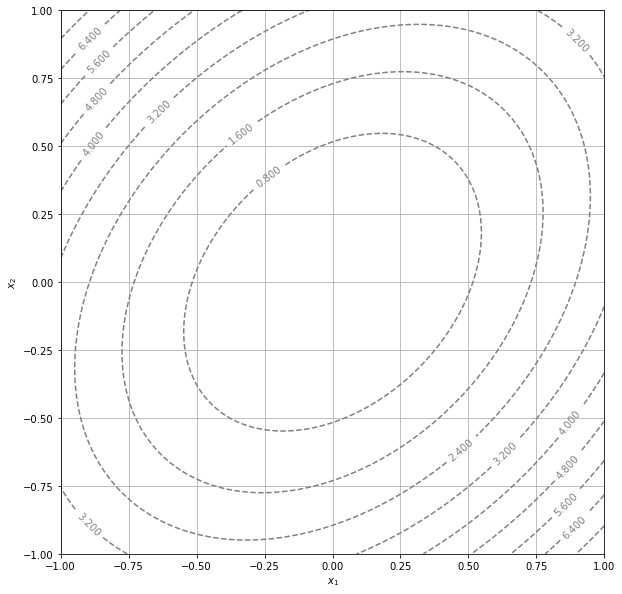

In [11]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [12]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

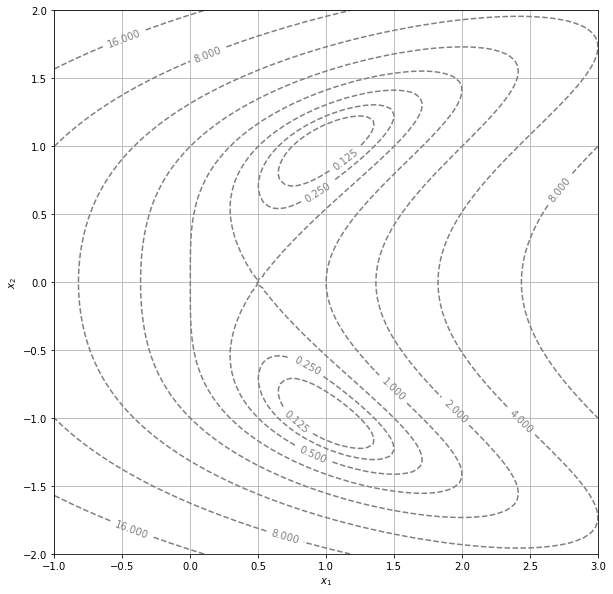

In [13]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [14]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

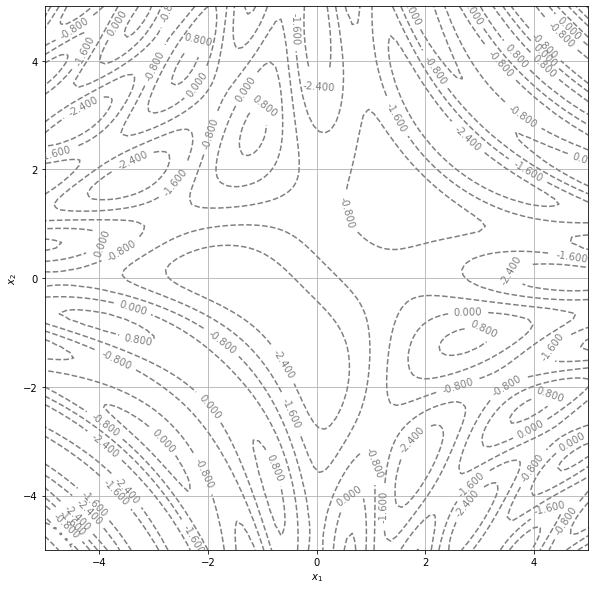

In [15]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

#### Réponse :

Montrons que  $E_{c} = \{(x,y) \in \mathbb{R} | f(x,y)=c \}$ est un fermé et borné c'est à dire qu'il s'agit là d'un ensemble compact.


 $E_{c}$ est fermé car il est l'image réciproque de $\{c\}$ par la fonction $f$ qui est continue.

 Supposons qu'il n'est pas borné: on peut donc construire une suite $(X_{k})_{k\in \mathbb{N}}$ telle que

 $\forall k \in \mathbb{N},  f(X_{k})=c$ et $\parallel X_{k} \parallel > 2^{k}$ 

 Ainsi en passant à la limite sur $k$ on obtient puisque $E_{c}$ est fermé $\lim\limits_{k \to \infty} f(X_{k}) = c$, or l'hypothèse donne  $\lim\limits_{k \to \infty} f(X_{k}) = +\infty$, ce qui est absurde.

 Ainsi $E_{c}$ est bien borné. 




Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$





#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

#### Réponse :

On se rend compte que $p(x_{1},x_{2})= \frac {\nabla f(x_{0})}{\parallel \nabla f(x_{0}) \parallel }\wedge (x-x_{0})$. Ceci est à voir en 3 dimensions avec la 3ème composante qui est nulle.

 Ceci correspond géométriquement à la projection orthogonale de $x$ sur la direction de $\nabla f(x_{0})$. 

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

#### Réponse :

Question 3:

Il s'agit de montrer que dans un voisinnage ouvert de $x_0$ noté $U$, on peut paramétriser l'ensemble de niveau $c = f(x_0)$ au moyen de $p(x_1,x_2)$, c'est à dire tel qu'il existe un $\varepsilon$ et une fonction continûment différentiable $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

Pour cela on se propose d'utiliser le théorème des fonctions implicites.
Pour cela on pose $g : \mathbb R^3 \rightarrow  \mathbb R^2$ $\newline$

$g :(x_1,x_2,t) \rightarrow$ $\begin{Bmatrix} f(x) -c\\t - p(x_1,x_2) \end{Bmatrix}$

En définissant g ainsi, on a bien la continu différentiabilité de g car f l'est et la deuxième composante de g ne pose pas de problèmes non plus. Donc g est continûment différentiable sur tout $\mathbb R²$

De plus $g$ est une application de $\mathbb R²$x$\mathbb R$ dans $\mathbb R²$ 

Il s'agit ensuite de s'assurer que $\partial_Xg$ est bien inversible au point $x_0$ puis par continuité de g on en déduira que $\partial_Xg$ est non nul dans un ouvert centré en $x_0$.   où $X = (x_1,x_2)$ 
En effet c'est bien le  cas car $\partial g=\begin{pmatrix} \partial_{x_1} f &\partial_{x_2} f & 0  \\ \frac{\partial_{x_2} f(x_0)}{||{\nabla}f(x_0)||} & \frac{-\partial_{x_1}f(x_0)}{||\nabla f (x_0)||} & 1 \end{pmatrix}$

On en déduit  donc que $\partial g_X$ = $\begin{pmatrix} \partial_{x_1} f &\partial_{x_2} f \\ \frac{\partial_{x_2} f(x_0)}{||{\nabla}f(x_0)||} & \frac{-\partial_{x_1}f(x_0)}{||\nabla f (x_0)||} \end{pmatrix}$

Or le déterminant de cette matrice appliqué au vecteur $x_0$ vaut $\nabla f(x0)$ qui, on le sait est non nul au voisinnage de $x_0$ donc en $x_0$. Par continuité de $\partial f_{x_1}$ et de $\partial f_{x_2}$ on en déduit que l'application $\partial g_X$ est non nul dans un voisinnage U du point $x_0$.

Ainsi on peut appliquer le théorème des fonctions implicites à la fonction g , il existe dès lors une unique fonction implicite $\gamma$: ]$-\epsilon, \epsilon$[ $\rightarrow \mathbb R²$ tel que dans le voisinnage ouvert U de $x_0$, 

$f(x_1,x_1) = c \leftrightarrow (x_1,x_2) = \gamma(t)$ où  $t = p(x_1,x_2)$.

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.
 
 
#### Réponse 

Le théorème des fonctions implicites nous donne 
$$
\gamma '(t)=-(\partial_{X}g(t,X))^{-1}. \partial_tg(t,X)
$$

c'est-à-dire:
$$
\gamma '(t) = \frac{||\nabla f(X_0)||}{\partial_{x_1}f(X)\partial_{x_1}f(X_0)+\partial_{x_2}f(X)\partial_{x_2}f(X_0)}.\begin{pmatrix} -\partial_{x_2}f(X)\\\partial_{x_1}f(X) \end{pmatrix}
$$
où $X=\gamma(t)$  
ce qui nous donne bien 
$$
\gamma '(t) . \nabla f(\gamma (t))=0
$$

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [16]:
N = 100
#il faut un espilon très petit pour avoir une bonne estimation de la solution de l'équation.
epsilon = 0.02

# détailler la justification, il s'agit d'une histoire de pixel pour
#le rendu visuel en effet 0.02 est la plus petite unité visible à l'écran. Deux points espacés de moins de ceci seront identiques à l'oeil nu


#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [17]:

def Newton(F, x0, y0, eps=0.01, N=100):
    for i in range(N):

        a = np.array([x0, y0]) - np.linalg.inv(J(F)(x0, y0))@F(x0, y0)
        xn, yn = a[0], a[1]
        if np.sqrt((xn - x0)**2 + (yn - y0)**2) <= eps:
            return np.array([xn, yn])
        x0, y0 = xn, yn
    else:
        raise ValueError(f"no convergence in {N} steps.")
    


#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

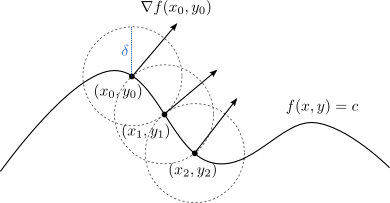

In [18]:
matrice_rotation = np.array([[0, 1], [-1, 0]])
#on définit une nouvelle fonction display_contour pour pouvoir superposer les lignes de niveau ainsi que notre tracé
def display_contour2(f, tableau, title, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.title(title)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.scatter(tableau[0], tableau[1], marker = '+')
    plt.gca().set_aspect("equal")
    plt.show()
    
 

# on définit des nouvelles fonctions avec des contraintes à respecter





In [19]:

def fonction_avec_contrainte1(x1, y1, c=1.6): 
    global level
    level = c
    return np.array([f1(x1, y1) - c, ((x1-x)**2+(y1-y)**2) - pas**2])

def fonction_avec_contrainte2(x1, y1, c=1.0): 
    global level
    level = c
    return np.array([f2(x1, y1) - c, ((x1-x)**2+(y1-y)**2) - pas**2])

def fonction_avec_contrainte3(x1, y1, c=-0.8): 
    global level
    level = c
    return np.array([f3(x1, y1) - c, ((x1-x)**2+(y1-y)**2) - pas**2])

In [20]:
   
def level_curve(f,g, x0, y0, eps, delta=0.1, N=100,n=100):
    global pas
    pas = delta
    points= np.zeros(shape=(2,N))
    points[0][0], points[1][0]= x0, y0
    for i in range(1,N) :
        global x
        global y
        x, y = points[0,i-1], points[1,i-1]
        gra = grad(f)(x,y)
        direction = (matrice_rotation@gra)*delta/np.linalg.norm(gra)
        #il s'agit de prendre la tangente à la courbe et de normaliser ce vecteur pour qu'il soit de longueur delta
        x1, y1 =  x + direction[0] , y + direction[1] # ce sont nos points pour initier newton
        points[0][i] = Newton(g, x1, y1, eps, n)[0]
        points[1][i] = Newton(g, x1, y1, eps, n)[1]
                                
    return points

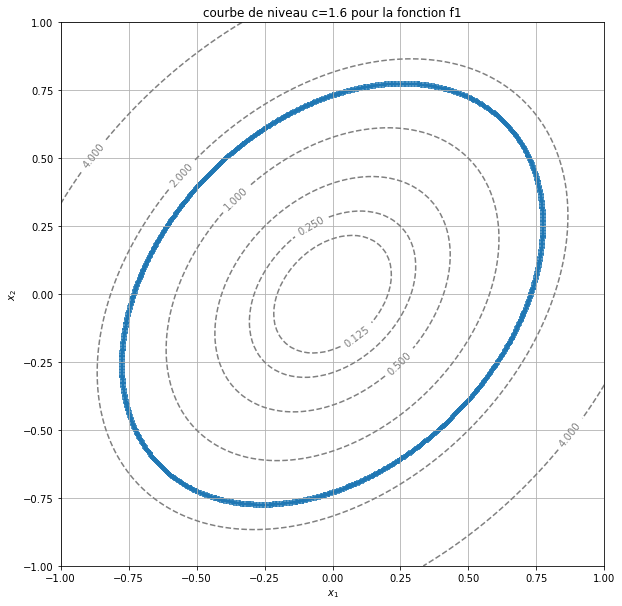

In [21]:
coordonnées1 = level_curve(f1, fonction_avec_contrainte1, 0.73, 0.0, 0.01, 0.1, 1000, 100)
                           
display_contour2(f1, coordonnées1, f"courbe de niveau c={level} pour la fonction f1", x=np.linspace(-1.0, 1.0, 100),
                y=np.linspace(-1.0, 1.0, 100),
                levels=[2**i for i in range(-3, 8)])



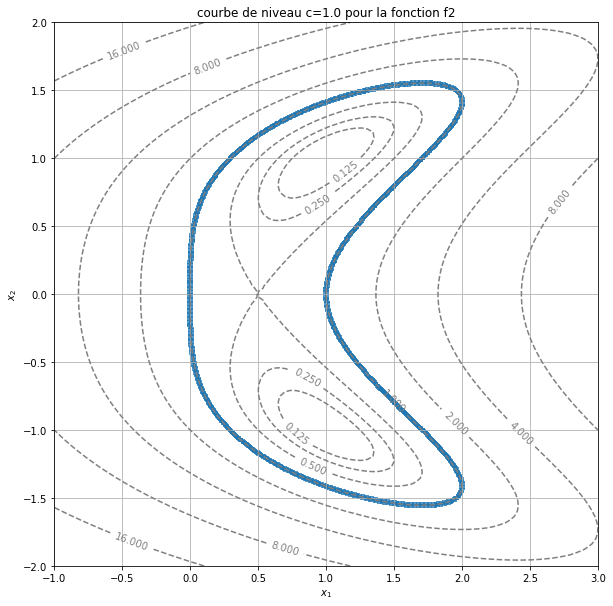

In [22]:
coordonnées2 = level_curve(f2, fonction_avec_contrainte2, 0.0, 0.0, 0.02, 0.1, 1000, 100)

display_contour2(f2, coordonnées2, f"courbe de niveau c={level} pour la fonction f2", x=np.linspace(-1.0, 3.0, 100),
                y=np.linspace(-2.0, 2.0, 100),
                levels=[2**i for i in range(-3, 8)])

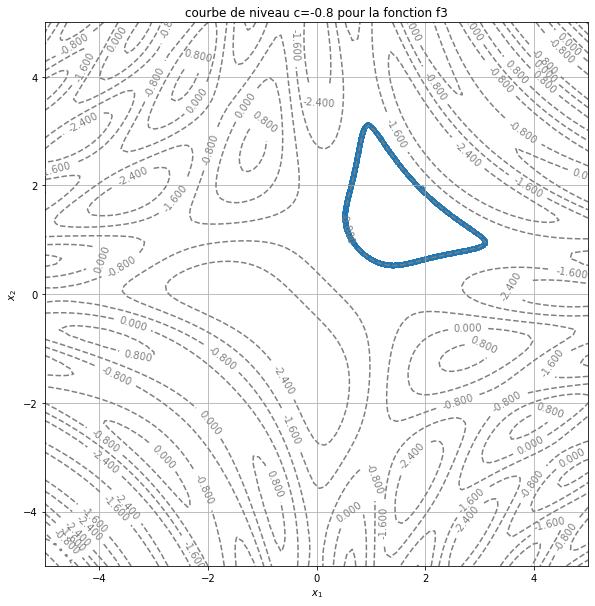

In [23]:
coordonnées3 = level_curve(f3, fonction_avec_contrainte3, 1.95, 1.95, 0.02, 0.1, 1000, 100)

display_contour2(
    f3, coordonnées3, f"courbe de niveau c={level} pour la fonction f3",
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

#à répondre

In [102]:
def intersection_segment(a0, b0, a1, b1, a2, b2, a3, b3):
    if a1 == a0 and a2!=a3:
        c = (b3-b2)/(a3-a2)
        d = b3 - c*a3
        if min(a2,a3)<=a1 and max(a2,a3)>=a1 and min(b0,b1)<=c*a1 + d <=max(b0,b1) :
            return False 
        else : return True
    elif a2==a3 and a0!=a1 :
        a = (b1-b0)/(a1-a0)
        b = b1 - a*a1
        if min(a0,a1)<=a2 and max(a0,a1)>=a2 and min(b2,b3)<=a*a2 + b <=max(b2,b3) :
            return False 
        else : return True
    elif a2==a3 and a1 ==a0 :
        if a2==a1 and (min(b2,b3)<b1<max(b2,b3) or min(b2,b3)<b0<max(b2,b3) or min(b0,b1)<b2<max(b0,b1) or min(b0,b1)<b3<max(b0,b1)) :
            return False
        else : return True
    else :
        a = (b1-b0)/(a1-a0)
        b = b1 - a*a1
        c = (b3-b2)/(a3-a2)
        d = b3 - c*a3

        if ((b2 >= a*a2 + b and b3 <= a*a3 + b) or (b2 <= a*a2 + b and b3 >= a*a3 + b))  and ((b0 >= c*a0 + d and b1 <= c*a1 + d) or ( b0 <= c*a0 + d and b1 >= c*a1+ d)):
            return False
        else:
            return True

In [25]:
def level_curve4(f, g, x0, y0, eps, delta=0.1, N=1000, n=100):
    global pas
    pas = delta
    points = np.zeros(shape=(2, N))
    points[0][0], points[1][0] = x0, y0
    for i in range(1, N):
        global x
        global y
        x, y = points[0, i-1], points[1, i-1]
        gra = grad(f)(x, y)
        direction = (matrice_rotation@gra)*delta/np.linalg.norm(gra)
        x1, y1 = x + direction[0], y + direction[1]
        # La boucle est-elle bouclée ?
        points[0][i], points[1][i] = Newton(g, x1, y1, eps, n)[
            0], Newton(g, x1, y1, eps, n)[1]
        if intersection_segment(x0, y0, points[0, 1], points[1, 1], points[0][i-1], points[1][i-1], points[0][i], points[1][i]) == False and (i != 1 and i != 2):
            return points[:, 0:i]
        elif i>3 and intersection_segment(points[0,2], points[1,2], points[0, 1], points[1, 1], points[0][i-1], points[1][i-1], points[0][i], points[1][i]) == False and (i != 1 and i != 2):
            return points[:, 0:i]
    return points

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

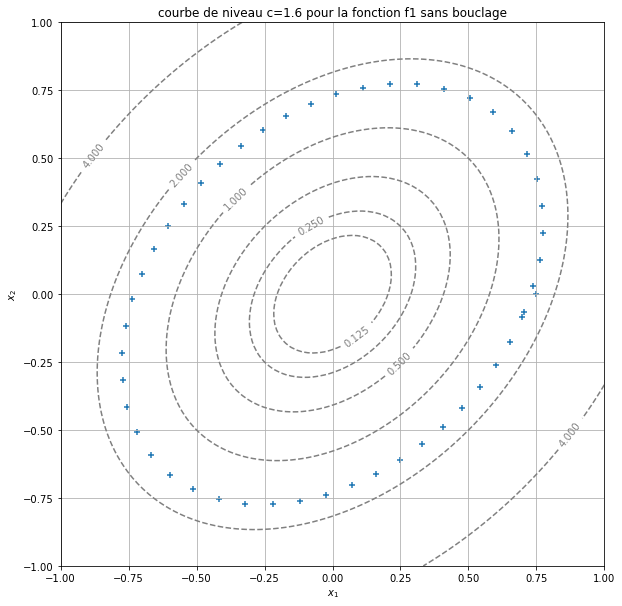

In [26]:
coordonnées41 = level_curve4(f1, fonction_avec_contrainte1, 0.75, 0.0, 0.01, 0.1, 1000, 100)
                           
display_contour2(f1, coordonnées41, f"courbe de niveau c={level} pour la fonction f1 sans bouclage", x=np.linspace(-1.0, 1.0, 100),
                y=np.linspace(-1.0, 1.0, 100),
                levels=[2**i for i in range(-3, 8)])


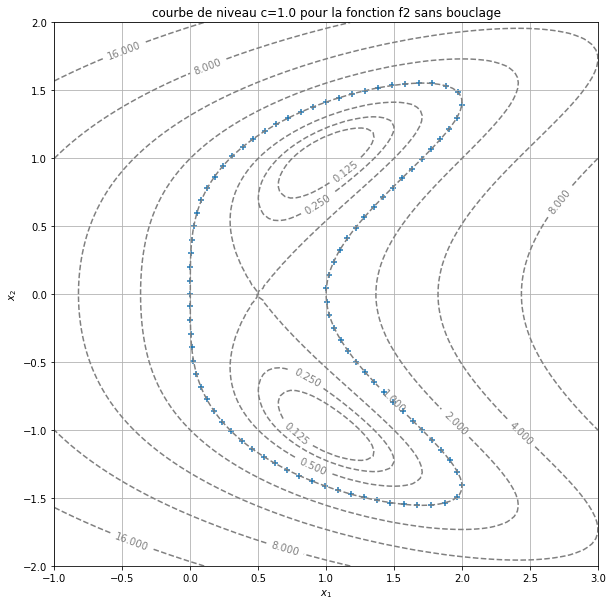

In [27]:

coordonnées42 = level_curve4(f2, fonction_avec_contrainte2, 0.0, 0.0, 0.02, 0.1, 1000, 100)
display_contour2(f2, coordonnées42, f"courbe de niveau c={level} pour la fonction f2 sans bouclage",  x=np.linspace(-1.0, 3.0, 100),
                y=np.linspace(-2.0, 2.0, 100),
                levels=[2**i for i in range(-3, 8)])

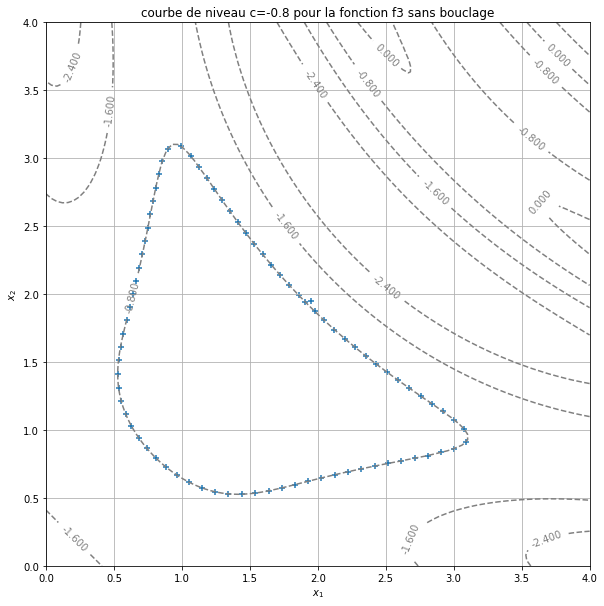

In [28]:
coordonnées43 = level_curve4(f3, fonction_avec_contrainte3, 1.95, 1.95, 0.01, 0.1, 3000, 100)

display_contour2(
    f3, coordonnées43, f"courbe de niveau c={level} pour la fonction f3 sans bouclage",
    x=np.linspace(0, 4.0, 100), 
    y=np.linspace(0, 4.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

#### Réponse 


En posant les équations du système, on obtient:
$$
\left\{
    \begin{array}{ll}
        a=x_1\\
        a+b+c=x_2\\
        d=y_1\\
        d+e+f= y_2\\
    \end{array}
\right.
$$

ainsi que 
$$
\begin{pmatrix}
b\\
e 
\end{pmatrix}
= 
\lambda. u_1
$$
où $\lambda \in \mathbb{R}_{*}+$
et 
$$
\begin{pmatrix}
b+2c\\
e+2f
\end{pmatrix}
= 
\mu. u_2
$$

où $\mu \in \mathbb{R}_{*}+$ .

En manipulant les équations, on obtient 
$P_2=P_1+ \lambda/2 . u_1+\mu/2 . u_2$

Cas 1 : $(u_1,u_2)$ est libre : 
on peut donc poser avec $B=(u_1,u_2)$ 
$$
P= \begin{pmatrix}
u_{11} & u_{21}\\
u_{12} & u_{22}
\end{pmatrix}
$$

la matrice inversible de changement de base.
On obtient donc: 
$$
\begin{pmatrix}
\lambda\\
\mu
\end{pmatrix}
=
2P^{-1}(P_2-P_1)
$$
vérifions le signe de $\lambda$ et de $\mu$:
en appliquant la formule précédente, on obtient:
$$
\lambda= 2\times\frac{u_{22}(x_2-x_1)-u_{21}(y_2-y_1)}{u_{11}u_{22}-u_{12}u_{21}}
$$

ainsi que 
$$
\mu= 2\times \frac{-u_{12}(x_2-x_1)+u_{11}(y_2-y_1)}{u_{11}u_{22}-u_{12}u_{21}}
$$

ainsi $\lambda$ et $\mu$ sont positifs si et seulement si 
$det(P)$, $u_{22}(x_2-x_1)-u_{21}(y_2-y_1)$ et $-u_{12}(x_2-x_1)+u_{11}(y_2-y_1)$ sont de même signe.


On connait donc $\lambda$ et $\mu$, donc on obtient les solutions:
$$
\left\{
    \begin{array}{ll}
        a=x_1\\
        b=\lambda u_{11}\\
        c=x_2-x_1-\lambda u_{11}\\
        d=y_1\\
        e=\lambda u_{12}\\
        f=y_2-y_1-\lambda u_{12}\\
    \end{array}
\right.
$$


Cas 2 : si $(u_1,u_2)$ est liée:

on pose $u_1=\alpha . u_2, \alpha \in \mathbb{R}$, ce qui donne en choisissant l'existence de $\lambda$ et $\mu$ tels que 
$$
\begin{pmatrix}
b\\
e
\end{pmatrix}
=\lambda . u_1 
$$
et 
$$
\begin{pmatrix}
b+2c\\
e+2f
\end{pmatrix}
= \mu . u_1
$$

en combinant les équations pour éliminer $\lambda$ et $\mu$, on obtient finalement, si $u_{11} \not ={0}$ :
$$
y_2= \frac{u_{12}}{u_{11}} . (x_2 - x_1)+y_1
$$
 c'est à dire que $(P_1P_2)$ est la direction des vecteurs $u_1$ et $u_2$, donc une interpolation possible vérifiant les conditions est le segment $[P_1P_2]$.

Si  $u_{11}=0$ , $x_1=x_2$ et puisque $u_{12} \not={0}$ alors $u_{21}=0$ et de même, la direction $(P_1P_2)$ est bien la direction des vecteurs.

Ainsi dans le cas où $B$ est liée, l'interpolation existe si et seulement si $(P_1P_2)$ dirige les deux vecteurs $u_1$ et $u_2$ et elle prend la forme:
$$
\forall t\in [0,1]:
\gamma (t)=
\begin{pmatrix}
x_1+(x_2-x_1)t\\
y_1+(y_2-y_1)t
\end{pmatrix}
$$


#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




In [34]:
def gamma(t, P1, P2, u1, u2):
    matrice_base = np.array([[u1[0], u2[0]], [u1[1], u2[1]]])
    t = np.array(t)
    # P2-P1
    ax = plt.axes
    P3 = np.array([P2[0] - P1[0], P2[1]-P1[1]])

    quantitetest1 = u2[1]*(P2[0]-P1[0])-u2[0]*(P2[1]-P1[1])
    quantitetest2 = -u1[1]*(P2[0]-P1[0])+u1[0]*(P2[1]-P1[1])
    determinant = np.linalg.det(matrice_base)

    if ((determinant < 0 and quantitetest1 < 0 and quantitetest2 < 0) or (determinant > 0 and quantitetest1 > 0 and quantitetest2 > 0)):
        coeff = (np.linalg.inv(matrice_base)@P3)[0] * 2
        coeff2 = (np.linalg.inv(matrice_base)@P3)[1] * 2
        a = P1[0]
        b = coeff * u1[0]
        c = P2[0]-P1[0] - coeff*u1[0]
        d = P1[1]
        e = coeff * u1[1]
        f = P2[1] - P1[1] - coeff*u1[1]
        x = a + b*t + c*t**2
        y = d + e*t + f*t**2
        return np.array([x, y])
    else:
        # dans le meilleur des cas on ne peut interpoler que par la
        # droite qui passe par les deux points et sinon l'énoncé dit de le faire quand même :
        x = P1[0] + (P2[0]-P1[0])*t
        y = P1[1] + (P2[1] - P1[1])*t
        return np.array([x, y])



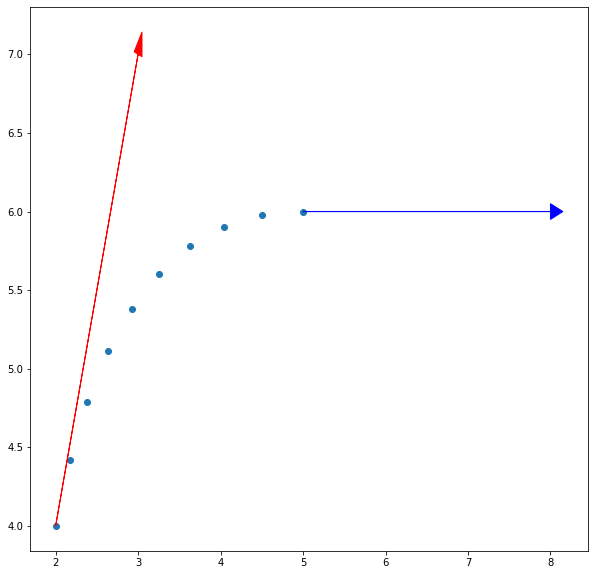

In [37]:
P1 = [2,4]
P2 = [5,6]
u1 = [1,3]
u2 = [3,0]
plt.scatter(gamma(np.linspace(0,1,10), P1, P2, u1, u2)[0][:], gamma(np.linspace(0,1,10), P1, P2, u1, u2)[1][:])
plt.arrow(P1[0], P1[1], u1[0], u1[1], color='red', head_width=0.1)
plt.arrow(P2[0], P2[1], u2[0], u2[1], color='blue', head_width=0.1)
plt.show()

### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [97]:

def level_curve7(f, g, x0, y0, eps, oversampling, delta=0.1, N=100, n=100):
    if oversampling == 1 :
        return level_curve4(f, g, x0, y0, eps, oversampling, delta=0.1, N=1000, n=100)
    else :
        global pas
        pas = delta
        points = np.zeros(shape=(2, N*oversampling))
        points[0][0], points[1][0] = x0, y0
        for i in range(oversampling, N*oversampling, oversampling):
            global x
            global y
            x, y = points[0, i-oversampling], points[1, i-oversampling]
            gra = grad(f)(x, y)
            direction = (matrice_rotation@gra)*delta/np.linalg.norm(gra)
            x1, y1 = x + direction[0], y + direction[1]
            # La boucle est-elle bouclée ?
            points[0][i], points[1][i] = Newton(g, x1, y1, eps, n)[
                0], Newton(g, x1, y1, eps, n)[1]
            tangente1 = tangente1 = matrice_rotation@gra
            tangente2 = matrice_rotation@grad(f)(points[0][i], points[1][i])
            for k in range(1,oversampling):
                interpolation = gamma(np.linspace(0,1,oversampling+1),[x,y],[points[0,i], points[1][i]],tangente1, tangente2) 
                points[0][k+i-oversampling], points[1,k+i-oversampling] = interpolation[0][k], interpolation[1][k]
            for j in range(1, N*oversampling):
                if intersection_segment(x0, y0, points[0, 1], points[1, 1], points[0][j-1], points[1][j-1], points[0][j], points[1][j]) == False and (j != 1 and j!= 2):
                    return points[:, 0:j]
                elif j>3 and intersection_segment(points[0,1], points[1,1], points[0, 2], points[1, 2], points[0][j], points[1][j-1], points[0][j-1], points[1][j]) == False:
                    return points[:, 0:j]
        return points

In [98]:
level_curve7(f1, fonction_avec_contrainte1, 0.75, 0.0, 0.01,10, 0.3, 100, 100)


array([[ 0.75      ,  0.74397096,  0.73597032, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.01622116, -0.03462521, ...,  0.        ,
         0.        ,  0.        ]])

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

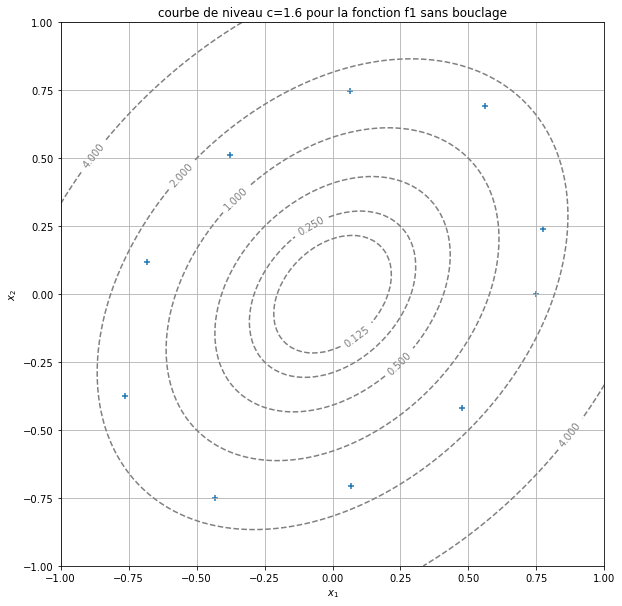

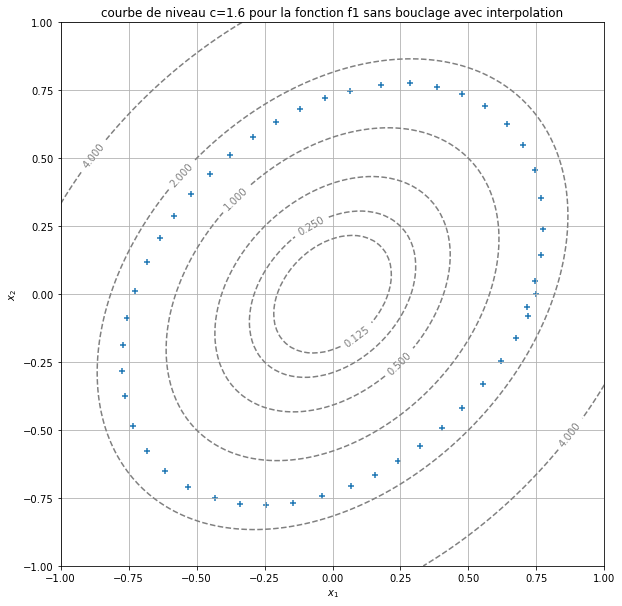

In [99]:
coordonnées71 = level_curve7(f1, fonction_avec_contrainte1, 0.75, 0.0, 0.02,5, 0.5, 1000, 100)
coordonnées41 = level_curve4(f1, fonction_avec_contrainte1, 0.75, 0.0, 0.02, 0.5, 1000, 100)

display_contour2(f1, coordonnées41, f"courbe de niveau c={level} pour la fonction f1 sans bouclage", x=np.linspace(-1.0, 1.0, 100),
                y=np.linspace(-1.0, 1.0, 100),
                levels=[2**i for i in range(-3, 8)])
display_contour2(f1, coordonnées71, f"courbe de niveau c={level} pour la fonction f1 sans bouclage avec interpolation", x=np.linspace(-1.0, 1.0, 100),
                y=np.linspace(-1.0, 1.0, 100),
                levels=[2**i for i in range(-3, 8)])

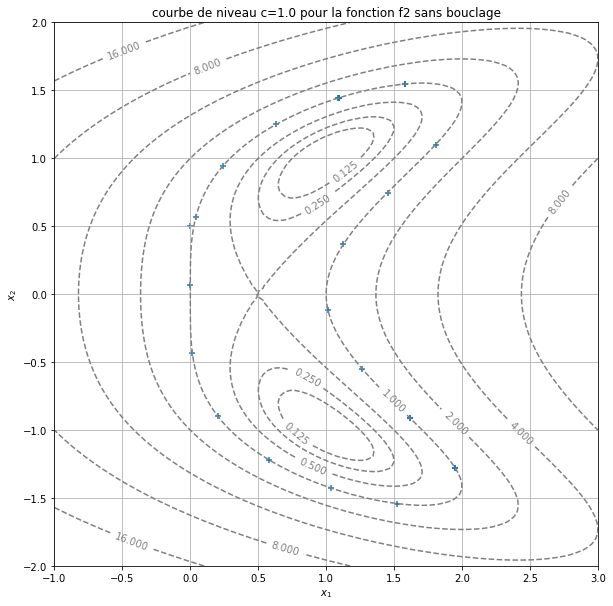

[[0.         0.02324995 0.05859665 ... 0.01453858 0.02572967 0.04009409]
 [0.5        0.58641213 0.67363279 ... 0.41152507 0.49626541 0.5660674 ]]


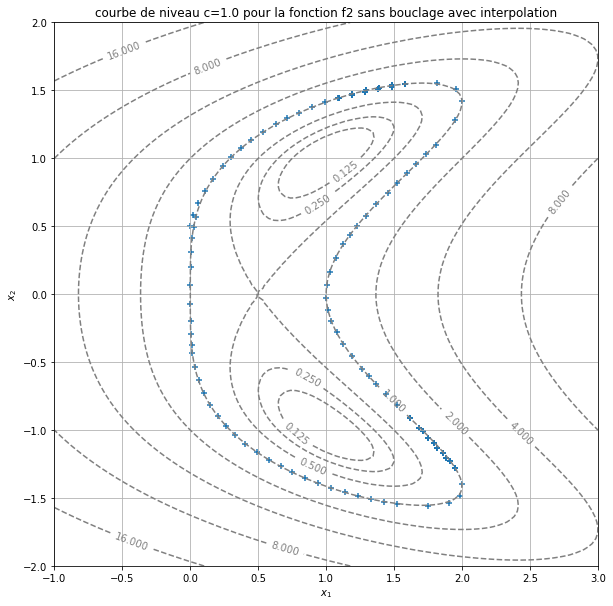

In [104]:
coordonnées42 = level_curve4(f2, fonction_avec_contrainte2, 0.0, 0.5, 0.02, 0.5, 1000, 100)
display_contour2(f2, coordonnées42, f"courbe de niveau c={level} pour la fonction f2 sans bouclage",  x=np.linspace(-1.0, 3.0, 100),
                y=np.linspace(-2.0, 2.0, 100),
                levels=[2**i for i in range(-3, 8)])

coordonnées72 = level_curve7(f2, fonction_avec_contrainte2, 0.0, 0.5, 0.02, 5, 0.5, 1000, 100)
display_contour2(f2, coordonnées72, f"courbe de niveau c={level} pour la fonction f2 sans bouclage avec interpolation",  x=np.linspace(-1.0, 3.0, 100),
                y=np.linspace(-2.0, 2.0, 100),
                levels=[2**i for i in range(-3, 8)])



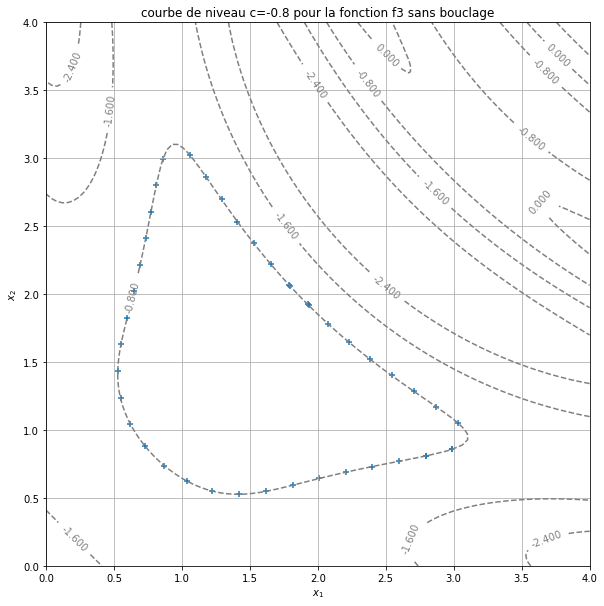

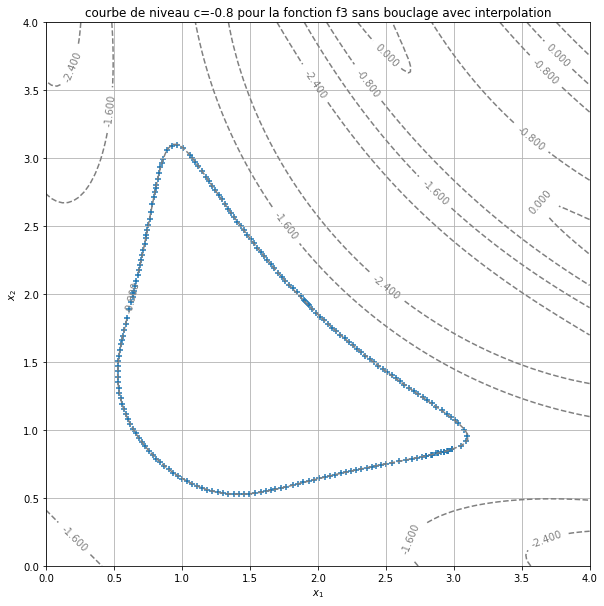

In [91]:
coordonnées43 = level_curve4(f3, fonction_avec_contrainte3, 1.93, 1.93, 0.02, 0.2, 1000, 100)

display_contour2(
    f3, coordonnées43, f"courbe de niveau c={level} pour la fonction f3 sans bouclage",
    x=np.linspace(0, 4.0, 100), 
    y=np.linspace(0, 4.0, 100), 
    levels=5, # 5 levels, automatically selected
)

coordonnées73 = level_curve7(f3, fonction_avec_contrainte3, 1.93, 1.93, 0.02, 5, 0.2, 1000, 100)

display_contour2(
    f3, coordonnées73, f"courbe de niveau c={level} pour la fonction f3 sans bouclage avec interpolation",
    x=np.linspace(0, 4.0, 100), 
    y=np.linspace(0, 4.0, 100), 
    levels=5, # 5 levels, automatically selected
)